In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset
from isaac.utils import plot_confusion_matrix
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS
from isaac.training import training_loop, evaluate_saved_model

In [4]:
BATCH_SIZE = 128
EPOCHS = 60
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

INPUT_DIM = len(YOKED_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

## Read dataset and preprocess it

In [5]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

100%|██████████| 399/399 [00:06<00:00, 63.06it/s]


In [24]:
first_half = [trial[:1801] for trial in exp1_trials]
second_half = [trial[-1801:] for trial in exp1_trials]
exp1_trials = first_half + second_half

yoked_trials = exp1_trials + exp2_force_trials + exp2_mass_trials

In [27]:
np.random.seed(0)
indices = np.arange(len(yoked_trials))
test_indices = np.random.choice(indices, 50, replace=False)
val_indices = np.random.choice(list(set(indices) - set(test_indices)), 125, replace=False)
train_indices = list(set(indices) - set(test_indices) - set(val_indices))

train_trials = [yoked_trials[i] for i in train_indices]
val_trials = [yoked_trials[i] for i in val_indices]
test_trials = [yoked_trials[i] for i in test_indices]

train_trials = exp2_force_trials + exp2_mass_trials
val_trials = first_half
test_trials = second_half

In [28]:
len(train_trials), len(val_trials), len(test_trials)

(909, 125, 50)

In [29]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], class_columns=[MASS_CLASS_COLS, FORCE_CLASS_COLS], 
                                  multiclass=True, training_columns=YOKED_TRAINING_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

100%|██████████| 50/50 [00:00<00:00, 261.32it/s]


In [30]:
train_loader, val_loader, test_loader = loaders

In [31]:
Y = [[], []]
for x,y in train_loader:
    for i in range(y.shape[1]):
        Y[i].extend(list(y[:, i]))

In [32]:
for i in range(2):
    counts = np.unique(Y[i], return_counts=True)[1]
    print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.35533553355335534
Majority class:  0.3718371837183718


In [33]:
class TopHeavyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout=0.):
        super(TopHeavyModel, self).__init__()
        # RNN
        self.lstm = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        # Readout layer
        self.gru1 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        
        out_1, _ = self.gru1(out)
        out_1 = self.fc1(out_1[:, -1, :]) 
        
        out_2, _ = self.gru2(out)
        out_2 = self.fc2(out_2[:, -1, :]) 
        return out_1, out_2

In [34]:
class BottomHeavyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout=0.):
        super(BottomHeavyModel, self).__init__()
        # RNN
        self.lstm = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        # Readout layer
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        
        out_1 = self.fc1(out[:, -1, :])         
        out_2 = self.fc2(out[:, -1, :]) 
        return out_1, out_2

## Define model, loss and optimizer

In [35]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = BottomHeavyModel(INPUT_DIM, HIDDEN_DIM, 5, OUTPUT_DIM, dropout=DROPOUT)
model = model.cuda()

mass_error = nn.CrossEntropyLoss().cuda()
force_error = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
model.train()

BottomHeavyModel(
  (lstm): GRU(23, 25, num_layers=5, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=25, out_features=3, bias=True)
  (fc2): Linear(in_features=25, out_features=3, bias=True)
)

In [37]:
def training_loop(model, optimizer, mass_error, force_error, train_loader, val_loader, num_epochs=200, print_stats_per_epoch=True,
                  seq_start=None, seq_end=None, step_size=None):    
    """Trains a model for <num_epochs> to minimize the <error> using the <optimizer>.
    Returns a list of epoch losses (averaged over batches) as well as validation accuracy"""
    
    best_model, best_mass_accuracy, best_force_accuracy = None, 0, 0
    epoch_losses = [[], []]
    epoch_accuracies = [[],[]]
    
    pbar = tqdm(range(num_epochs))
    
    for epoch in pbar:
        model.train()
        
        mass_total_loss = 0.
        force_total_loss = 0.

        for x, y in train_loader:

            x = Variable(x[:, seq_start:seq_end:step_size, :])
            y = Variable(y)
            
            mass_y = y[:, 0]
            force_y = y[:, 1]
            
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            mass_y_hat, force_y_hat = model(x)
            # Calculate softmax and cross entropy loss
            mass_loss = mass_error(mass_y_hat, mass_y)
            force_loss = force_error(force_y_hat, force_y)
            
            # Calculating gradients
            torch.autograd.backward([mass_loss, force_loss])
            
            # Update parameters
            optimizer.step()

            mass_total_loss += mass_loss.item()
            force_total_loss += force_loss.item()

        epoch_losses[0].append(mass_total_loss / len(train_loader))
        epoch_losses[1].append(force_total_loss / len(train_loader))

        model.eval()
        train_mass_accuracy, train_force_accuracy = evaluate(model, train_loader)
        epoch_accuracies[0].append((train_mass_accuracy, train_force_accuracy))
        val_mass_accuracy, val_force_accuracy = evaluate(model, val_loader)
        epoch_accuracies[1].append((val_mass_accuracy, val_force_accuracy))

        if val_mass_accuracy > best_mass_accuracy:
            best_mass_model = deepcopy(model)
            best_mass_accuracy = val_mass_accuracy
        
        if val_force_accuracy > best_force_accuracy:
            best_force_model = deepcopy(model)
            best_force_accuracy = val_force_accuracy
            
        if print_stats_per_epoch:
            pbar.set_description("Mass_loss (%.2f) Mass Train_acc (%.2f) Mass Val_acc (%.2f) Force_loss (%.2f)  Force Train_acc (%.2f) Force Val_acc (%.2f)" % 
                                 (epoch_losses[0][-1], train_mass_accuracy, val_mass_accuracy, epoch_losses[1][-1], train_force_accuracy, val_force_accuracy))
    
    return epoch_losses, epoch_accuracies, [best_mass_model, best_force_model]

In [38]:
def get_current_prediction_and_number_of_correct_examples(y_hat, y_val):
    current_prediction = torch.max(y_hat.data, 1)[1]
    correct = (current_prediction == y_val).sum().cpu().numpy()
    return current_prediction, correct

def evaluate(model, val_loader, return_predicted=False, seq_start=None, seq_end=None, step_size=None):
    predicted = [[], []]
    accuracies = [[], []]

    mass_correct = 0
    force_correct = 0
    total = 0
    
    for x_val, y_val in val_loader:
        total += y_val.size(0)
        mass_val = y_val[:, 0]
        force_val = y_val[:, 1]

        x_val = Variable(x_val[:, seq_start:seq_end:step_size, :])
        mass_hat, force_hat = model(x_val)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(mass_hat, mass_val)
        mass_correct += correct
        predicted[0].extend(current_prediction)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(force_hat, force_val)
        force_correct += correct
        predicted[1].extend(current_prediction)
        
    accuracies[0] = 100 * mass_correct / float(total)
    accuracies[1] = 100 * force_correct / float(total)
    
    if return_predicted:
        return accuracies[0], accuracies[1], predicted[0], predicted[1]
    
    return accuracies[0], accuracies[1]

## Train model and plot loss and accuracy

In [39]:
epoch_losses, epoch_accuracies, best_models = training_loop(model, optimizer, mass_error, force_error, train_loader, val_loader, EPOCHS, 
                                                           seq_end=SEQ_END, step_size=STEP_SIZE)

Mass_loss (0.63) Mass Train_acc (68.65) Mass Val_acc (38.40) Force_loss (0.48)  Force Train_acc (79.21) Force Val_acc (40.80): 100%|██████████| 60/60 [04:36<00:00,  4.65s/it]


In [40]:
best_mass_model, best_force_model = best_models

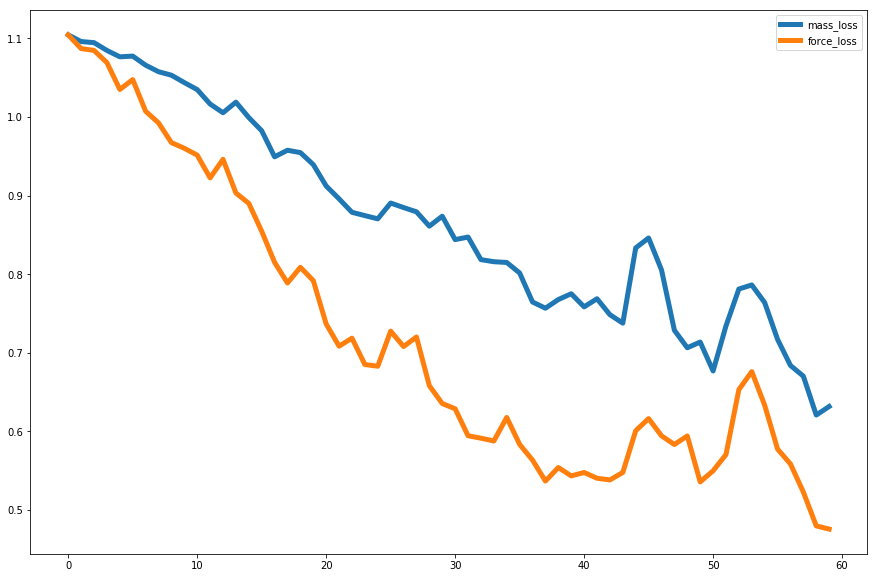

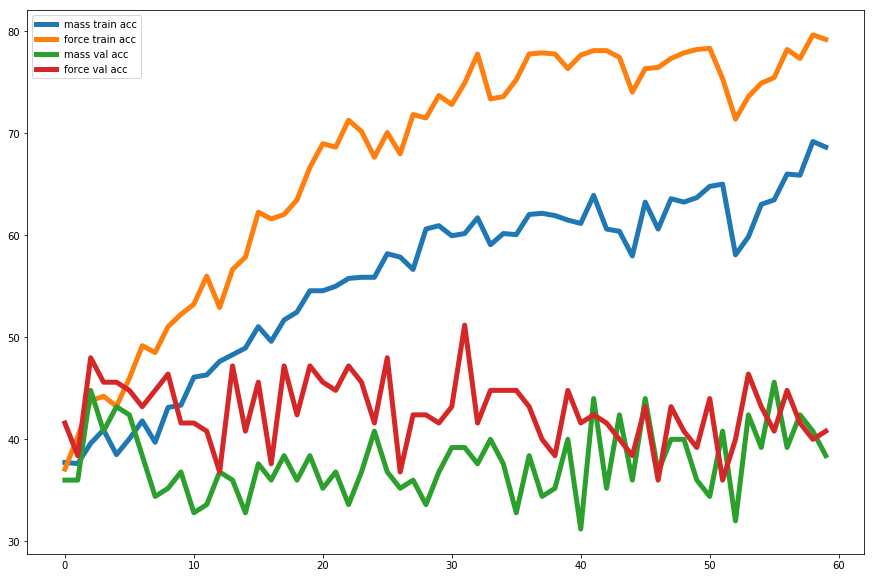

In [41]:
plt.figure(figsize=(15, 10))
lines = plt.plot(np.array(epoch_losses).T, linewidth=5)
plt.legend(lines, ["mass_loss", "force_loss"])
plt.show()
plt.figure(figsize=(15, 10))
mass_lines = plt.plot(np.array(epoch_accuracies[0]), linewidth=5)
force_lines = plt.plot(np.array(epoch_accuracies[1]), linewidth=5)
plt.legend(iter(mass_lines + force_lines), ["mass train acc", "force train acc", "mass val acc", "force val acc"])
plt.show()

In [42]:
max(np.array(epoch_accuracies[1])[:,0]), max(np.array(epoch_accuracies[1])[:,1])

(45.6, 51.2)

## Save model and scaler

In [43]:
torch.save(best_mass_model.state_dict(), "models/passive_mass_dual_model.pt")
torch.save(best_force_model.state_dict(), "models/passive_force_dual_model.pt")

In [44]:
joblib.dump(scaler, "scalers/passive_dual_scaler.sk")

['scalers/passive_dual_scaler.sk']

## Load model and evaluate

In [45]:
def plot(predicted, i, class_columns):
    predicted = [pred.cpu() for pred in predicted]
    Y_test = np.concatenate([y[:, i].cpu().numpy() for x, y in test_loader])

    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=False)
    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=True)

In [46]:
scaler = joblib.load("scalers/passive_dual_scaler.sk")

34.0


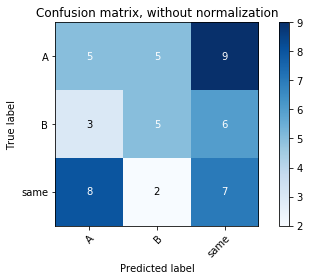

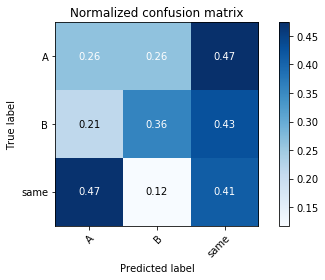

In [47]:
model = BottomHeavyModel(INPUT_DIM, HIDDEN_DIM, 5, OUTPUT_DIM)
model.load_state_dict(torch.load("models/passive_mass_dual_model.pt"))
model.eval()
model = model.cuda()
mass_accuracy, _, mass_predicted, _ = evaluate(model, test_loader, return_predicted=True)
print(mass_accuracy)
plot(mass_predicted, 0, MASS_CLASS_COLS)

32.0


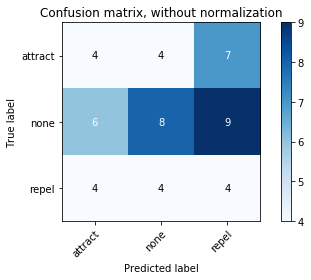

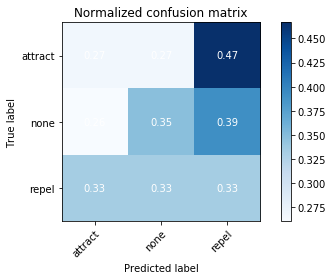

In [48]:
model = BottomHeavyModel(INPUT_DIM, HIDDEN_DIM, 5, OUTPUT_DIM)
model.load_state_dict(torch.load("models/passive_force_dual_model.pt"))
model.eval()
model = model.cuda()
_, force_accuracy, _, force_predicted = evaluate(model, test_loader, return_predicted=True)
print(force_accuracy)
plot(force_predicted, 1, FORCE_CLASS_COLS)